Importação das Bibliotecas

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rasterio as rs
from skimage.transform import resize

Inicialização das Variáveis que seram utilizadas dirante a execução do código

In [2]:
IMG_HEIGHT = 64  # Definir a altura das imagens
IMG_WIDTH = 64   # Definir a largura das imagens
IMG_MASK_CHANNELS = 1  # Número de canais de imagem mascara
IMG_CHANNELS = 2  # Número de canais de imagem (bandas 11 e 12)
IMG_COLOR_CHANNELS = 3  # Número de canais de imagem coloridas
TAMANHO_RECORTE = IMG_HEIGHT
NUMERO_IMAGEN = 1

Diretório das Imagens e Saídas de .CSV e DataFrame

In [3]:
# Local onde as imagens seram salvas em seu computador
path = "/home/cristiano/Imagens/"
# path = "/home/emanoelcepr/Imagens/"

# Treino Sentinel-2
# origem =  path + "imagens_originais/Sentinel-2/treino/"
# diretorio_imagens =  path + "imagens_originais/Sentinel-2/treino_processadas/"

# # Teste Sentinel-2
origem = path + "imagens_originais/Sentinel-2/teste/"
diretorio_imagens =  path + "imagens_originais/Sentinel-2/teste_processadas/"

Neste ponto é criado a estrutura que será a entrada para o treinamento da Rede Neural Convolucional. 

Sentinel-2

In [4]:
# Função para redimensionar as imagens de entrada para o tamanho desejado
def redimensionar_imagem(imagem, altura_desejada, largura_desejada):
    return resize(imagem, (altura_desejada, largura_desejada), mode='constant', preserve_range=True)

# Obter número de imagens de treino
NUM_TRAIN_IMAGES = len([f for f in os.listdir(diretorio_imagens) if "Mask" in f])

# Obter listas de nomes de arquivo Sentinel-2
banda11_list = sorted([f for f in os.listdir(diretorio_imagens) if "B11_(Raw)" in f])
banda12_list = sorted([f for f in os.listdir(diretorio_imagens) if "B12_(Raw)" in f])
seg_list = sorted([f for f in os.listdir(diretorio_imagens) if "Mask" in f])
color_list = sorted([f for f in os.listdir(diretorio_imagens) if "Wildfires" in f])

with pd.option_context("display.max_columns", None):
    df = pd.DataFrame({'banda11': banda11_list, 'banda12': banda12_list, 'seg': seg_list, 'color': color_list})

# Obter listas de IDs
train_banda11_id_list = df['banda11'].tolist()
train_banda12_id_list = df['banda12'].tolist()
train_mask_id_list = df['seg'].tolist()
train_color_id_list = df['color'].tolist()

#criando as matrizes para armazenar as imagens 
# X_train = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
# Y_train = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_MASK_CHANNELS), dtype=bool)
# Z_train = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_COLOR_CHANNELS), dtype=np.float32)

X_test = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_MASK_CHANNELS), dtype=bool)
Z_test = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_COLOR_CHANNELS), dtype=np.float32)

# Iterar sobre as listas usando enumerate
for i, (banda11_id, banda12_id, mask_id, color_id) in enumerate(zip(train_banda11_id_list, train_banda12_id_list, train_mask_id_list, train_color_id_list)):
    # Construir caminhos completos
    path_banda11 = os.path.join(diretorio_imagens, banda11_id)
    path_banda12 = os.path.join(diretorio_imagens, banda12_id)
    path_seg = os.path.join(diretorio_imagens, mask_id)
    path_color = os.path.join(diretorio_imagens, color_id)

    try:
        # Ler as imagens
        with rs.open(path_banda11) as img11, rs.open(path_banda12) as img12, rs.open(path_seg) as img_seg, rs.open(path_color) as img_color:
            banda11 = img11.read(1)
            banda12 = img12.read(1)
            seg = img_seg.read(1)
            color = img_color.read(1)

        # Juntar as bandas
        bandas = np.dstack((banda11, banda12))

        # Redimensionar as bandas para o tamanho desejado
        bandas_redimensionadas = redimensionar_imagem(bandas, IMG_HEIGHT, IMG_WIDTH)

        # Transformar bandas em valores entre 0 e 255
        bandas_redimensionadas = (bandas_redimensionadas / np.max(bandas_redimensionadas)) * 255

        # Inserir a imagem em X_train/X_test
        # X_train[i] = bandas_redimensionadas
        X_test[i] = bandas_redimensionadas

        # Redimensionar a máscara para a forma (IMG_HEIGHT, IMG_WIDTH, 1)
        mask = resize(seg, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)

        # Normalizar valores da máscara para True/False (ou 0/1)
        mask = mask.astype(bool)

        # Inserir a máscara em Y_train/Y_test
        # Y_train[i] = mask
        Y_test[i] = mask

        # Inserir a imagem em Z_train/Z_test
        # Z_train[i] = resize(color, (IMG_HEIGHT, IMG_WIDTH, IMG_COLOR_CHANNELS), mode='constant', preserve_range=True)
        Z_test[i] = resize(color, (IMG_HEIGHT, IMG_WIDTH, IMG_COLOR_CHANNELS), mode='constant', preserve_range=True)

    except (rs.errors.RasterioIOError, FileNotFoundError) as e:
        print(f"Erro ao abrir a imagem {banda11_id}: {e}")

# print('Shape do X_train:', X_train.shape)
# print('Shape do Y_train:', Y_train.shape)
# print('Shape do Z_train:', Z_train.shape)

print('Shape do X_test:', X_test.shape)
print('Shape do Y_test:', Y_test.shape)
print('Shape do Z_test:', Z_test.shape)


/home/cristiano/.local/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Shape do X_test: (1341, 64, 64, 2)
Shape do Y_test: (1341, 64, 64, 1)
Shape do Z_test: (1341, 64, 64, 3)


Salva as entradas da Rede

In [5]:
# # Salvar X_train
# X_train_file = os.path.join(diretorio_imagens, 'X_train.npy')
# np.save(X_train_file, X_train)

# # Salvar Y_train
# Y_train_file = os.path.join(diretorio_imagens, 'Y_train.npy')
# np.save(Y_train_file, Y_train)

# # Salvar Y_train
# Z_train_file = os.path.join(diretorio_imagens, 'Z_train.npy')
# np.save(Z_train_file, Z_train)

Visualização de uma imagem a partir dos arquivos salvos.

In [6]:

# # Selecionar a primeira amostra da array X_test, que contém a imagem composta pelas duas bandas
# bandas = X_train[6]
# color = Z_train[6]

# # # Separar as bandas individuais (assumindo que as bandas estão na última dimensão)
# banda11 = bandas[:, :, 0]
# banda12 = bandas[:, :, 1]

# # # Plotar as bandas individualmente
# plt.subplot(1, 3, 1)
# plt.imshow(banda11, cmap='gray')
# plt.title('Banda 11')

# plt.subplot(1, 3, 2)
# plt.imshow(banda12, cmap='gray')
# plt.title('Banda 12')

# plt.subplot(1, 3, 3)
# color_normalized = color / 255.0
# plt.imshow(color_normalized)
# plt.title('Color')


# plt.show()

Salva as entradas da Rede

In [7]:
# Salvar X_test
X_test_file = os.path.join(diretorio_imagens, 'X_test.npy')
np.save(X_test_file, X_test)

# Salvar Y_train
Y_test_file = os.path.join(diretorio_imagens, 'Y_test.npy')
np.save(Y_test_file, Y_test)

# Salvar Z_train
Z_test_file = os.path.join(diretorio_imagens, 'Z_test.npy')
np.save(Z_test_file, Z_test)

Visualização de uma imagem a partir dos arquivos salvos.

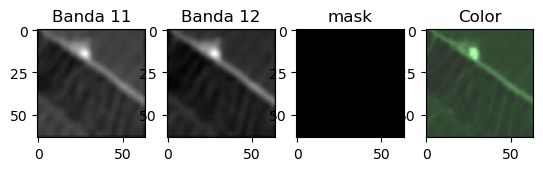

In [13]:

# Selecionar a primeira amostra da array X_test, que contém a imagem composta pelas duas bandas
bandas = X_test[9]
mask = Y_test[9]
color = Z_test[9]

# Separar as bandas individuais (assumindo que as bandas estão na última dimensão)
banda11 = bandas[:, :, 0]
banda12 = bandas[:, :, 1]

# Plotar as bandas individualmente
plt.subplot(1, 4, 1)
plt.imshow(banda11, cmap='gray')
plt.title('Banda 11')

plt.subplot(1, 4, 2)
plt.imshow(banda12, cmap='gray')
plt.title('Banda 12')

plt.subplot(1, 4, 3)
plt.imshow(mask, cmap='gray')
plt.title('mask')

plt.subplot(1, 4, 4)
color_normalized = color / 255.0
plt.imshow(color_normalized)
plt.title('Color')

plt.show()

vou passar o indice e a posição do pixel e a função vai no diretório onde esta salvo as imagem e vai procurar no meta dados a longitute e a latitude da imagem.